In [1]:
import torch
from torch.utils.data import DataLoader
from src.model import MineSweeperDataset, PatchMLPModel, OnHotEncodingTransform, Game

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [3]:
train = Game(n = 10000)
train.random_open(0.5)
train.random_flags(0.3)
test = Game(n = 100)
test.random_open(0.5)
test.random_flags(0.3)
transform = OnHotEncodingTransform(2)
training_data = MineSweeperDataset(train, transform)
test_data = MineSweeperDataset(test, transform)
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)
model = PatchMLPModel(2)
optimizer = torch.optim.Adam(model.model.parameters(), lr=0.0001)

In [4]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(train_dataloader, optimizer, device)
    model.test(test_dataloader, device)

Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------


In [5]:
import plotly_express as px
import pandas as pd
df = pd.DataFrame({'train': model.train_loss_log, 'test': model.test_loss_log})
px.line(df)

In [6]:
g = Game(n=1)
g.random_open(0.5)
g.random_flags(0.5)
dataset = MineSweeperDataset(g, transform)
x, _ = dataset[0]

In [7]:
p = model.model(x.unsqueeze(0)).view(g.mines.shape).detach().numpy()

(<Figure size 1800x600 with 1 Axes>, array([<Axes: >, <Axes: >], dtype=object))

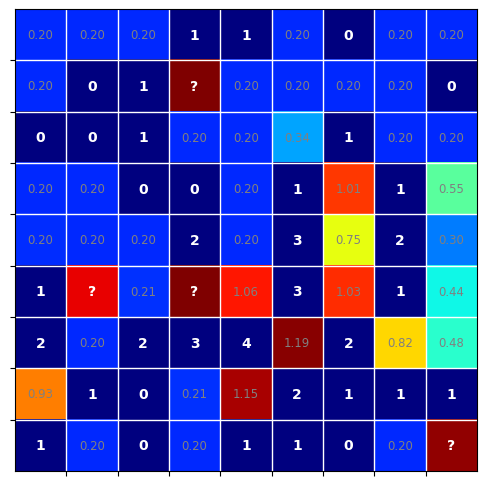

In [8]:
g.pyplot_games(mine_probs=p)